In [353]:
%load_ext autoreload
%autoreload 2

from MyClassifier_13 import MyClassifier
import numpy as np
import requests, gzip, os, hashlib
import matplotlib.pyplot as plt

np.random.seed(1) # for reproducibility

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [354]:
### driver code
use_mnist = False # Set to True to use MNIST, False to use synthetic data (smaller and faster)

if use_mnist:
    # fetching the MNIST data

    ### change this line of code to put the data where you want it
    path = "./testing"
    os.makedirs(path, exist_ok=True)
    ###

    def fetch(url):
        fp = os.path.join(path, hashlib.md5(url.encode('utf-8')).hexdigest())
        if os.path.isfile(fp):
            with open(fp, "rb") as f:
                data = f.read()
        else:
            with open(fp, "wb") as f:
                data = requests.get(url).content
                f.write(data)
        return np.frombuffer(gzip.decompress(data), dtype=np.uint8).copy()

    y_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 784))
    s_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
    y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 784))
    s_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

    # taking only 1's and 7's
    y_train = y_train[(s_train == 1) | (s_train == 7)]
    s_train = s_train[(s_train == 1) | (s_train == 7)].astype(np.int8)
    y_test = y_test[(s_test == 1) | (s_test == 7)]
    s_test = s_test[(s_test == 1) | (s_test == 7)].astype(np.int8)

    # map 1's to s = 1 and 7's to s = -1
    s_train[s_train == 1] = 1
    s_train[s_train == 7] = -1
    s_test[s_test == 1] = 1
    s_test[s_test == 7] = -1

    # N_train = 1000 # reduce training size so it completes faster
    N_train = y_train.shape[0] # keep all training data

    # Randomly select and randomly order
    training_indices = np.random.choice(range(y_train.shape[0]), size=N_train, replace=False)
    y_train = y_train[training_indices]
    s_train = s_train[training_indices]

else:
    # synthetic dataset
    def make_dataset(N):
        Y = np.concatenate((np.random.multivariate_normal(np.array([-1,1]), np.identity(2), N//2), np.random.multivariate_normal(np.array([1,-1]), np.identity(2), N//2)))
        S = np.concatenate((-np.ones(N//2, dtype=np.int8), np.ones(N//2, dtype=np.int8)))
        order = list(range(Y.shape[0]))
        np.random.shuffle(order) # randomly order
        Y = Y[order]
        S = S[order]
        return (Y, S)

    N_train = 1000
    N_test = 1000

    y_train, s_train = make_dataset(N_train)
    y_test, s_test = make_dataset(N_test)


In [355]:
print(y_train.shape)
print(s_train.shape)
print(y_test.shape)
print(s_test.shape)

# check for roughly equal amounts of training samples per class
print()
print((s_train[s_train == 1]).shape)
print((s_train[s_train == -1]).shape)

(13007, 784)
(13007,)
(2163, 784)
(2163,)

(6742,)
(6265,)


In [356]:
# define function
def percentage_correct(inferences, labels):
    N_test = inferences.shape[0]
    return 1/N_test * np.ones(N_test)@(labels == inferences)

In [357]:
# train all at once
model = MyClassifier(y_train.shape[1])
model.train(y_train, s_train)

inferences = model.test(y_test)
print("test dataset percent correct: {}".format(percentage_correct(inferences, s_test)))
# print(np.linalg.norm(model.W))

if y_train.shape[1] == 2:
    # Original data
    x1 = [val[0] for val in y_train[s_train==-1]]
    y1 = [val[1] for val in y_train[s_train==-1]]
    plt.scatter(x1, y1)

    x2 = [val[0] for val in y_train[s_train==1]]
    y2 = [val[1] for val in y_train[s_train==1]]
    plt.scatter(x2, y2)

    x_plane = np.linspace(np.amin(y_train[:,0]), np.amax(y_train[:,0]), 100)
    y_plane = -1/model.W[1] * (model.W[0]*x_plane + model.w)
    plt.plot(x_plane, y_plane, '-r')

    x_plane_margin1 = np.linspace(np.amin(y_train[:,0]), np.amax(y_train[:,0]), 100)
    y_plane_margin1 = -1/model.W[1] * (model.W[0]*x_plane + model.w + 1)
    plt.plot(x_plane_margin1, y_plane_margin1, '-k')

    x_plane_margin2 = np.linspace(np.amin(y_train[:,0]), np.amax(y_train[:,0]), 100)
    y_plane_margin2 = -1/model.W[1] * (model.W[0]*x_plane + model.w - 1)
    plt.plot(x_plane_margin2, y_plane_margin2, '-k')

    plt.show()

test dataset percent correct: 0.9930651872399597


/opt/homebrew/lib/python3.9/site-packages/cvxpy/problems/problem.py:1294: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


On average, used 330.3 out of 13007 samples (2.539401860536634%)
Average accuracy: 0.9906380027739402


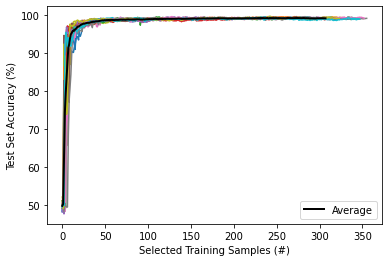

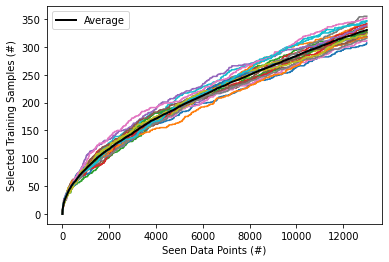

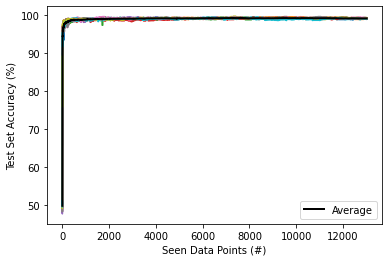

On average, reaches 50.0% accuracy after these training sample counts: [1]
On average, reaches 65.0% accuracy after these training sample counts: [3]
On average, reaches 80.0% accuracy after these training sample counts: [5]
On average, reaches 95.0% accuracy after these training sample counts: [11]


In [358]:
# train online
accuracy_vs_selected_samples_all_runs = []
selected_samples_vs_seen_samples_all_runs = []

for _ in range(30): # average over multiple runs
    order = list(range(y_train.shape[0]))
    np.random.shuffle(order) # randomly order
    y_train = y_train[order]
    s_train = s_train[order]

    model = MyClassifier(y_train.shape[1])
    accuracy_vs_selected_samples = [] # indexed by number of training samples used
    selected_samples_vs_seen_samples = []

    inferences = model.test(y_test)
    accuracy_vs_selected_samples.append(percentage_correct(inferences, s_test)) # first element corresponds to 0 training samples
    selected_samples_vs_seen_samples.append(0)

    for i in range(len(y_train)):
        prev_size = model.y_train.shape[0]
        model.sample_selection(y_train[i], s_train[i])
        if model.y_train.shape[0] > prev_size:
            model.train()
            inferences = model.test(y_test)
            accuracy_vs_selected_samples.append(percentage_correct(inferences, s_test))
        selected_samples_vs_seen_samples.append(model.y_train.shape[0])

    accuracy_vs_selected_samples_all_runs.append(accuracy_vs_selected_samples)
    selected_samples_vs_seen_samples_all_runs.append(selected_samples_vs_seen_samples)

    ## Final weights and bias
    # print(model.W)
    # print(model.w)

accuracy_vs_seen_samples_all_runs = []
for selected_samples_vs_seen_samples, accuracy_vs_selected_samples in zip(selected_samples_vs_seen_samples_all_runs, accuracy_vs_selected_samples_all_runs):
    accuracy_vs_selected_samples = np.array(accuracy_vs_selected_samples)
    accuracy_vs_seen_samples_all_runs.append(accuracy_vs_selected_samples[selected_samples_vs_seen_samples])

accuracy_vs_seen_samples_all_runs = np.array(accuracy_vs_seen_samples_all_runs)
avg_accuracy_vs_seen_samples = np.mean(accuracy_vs_seen_samples_all_runs, axis=0)

selected_samples_vs_seen_samples_all_runs = np.array(selected_samples_vs_seen_samples_all_runs)
avg_selected_samples_vs_seen_samples = np.mean(selected_samples_vs_seen_samples_all_runs, axis=0)

avg_accuracy_vs_selected_samples = [] # only average up until the last sample for the run with the least samples
for i in range(np.amin(list(len(accuracy_vs_selected_samples_all_runs[i]) for i in range(len(accuracy_vs_selected_samples_all_runs))))):
    avg_accuracy_vs_selected_samples.append(np.mean(list(accuracy_vs_selected_samples_all_runs[j][i] for j in range(len(accuracy_vs_selected_samples_all_runs)))))
avg_accuracy_vs_selected_samples = np.array(avg_accuracy_vs_selected_samples)

assert(y_train.shape[0] == len(avg_selected_samples_vs_seen_samples)-1) # sanity check
print("On average, used {} out of {} samples ({}%)".format(np.mean(avg_selected_samples_vs_seen_samples[-1]), y_train.shape[0], 100*np.mean(avg_selected_samples_vs_seen_samples[-1])/y_train.shape[0]))

# average accuracy after training the last sample in each run
print("Average accuracy: {}".format(np.mean(list(accuracy_vs_selected_samples_all_runs[i][-1] for i in range(len(accuracy_vs_selected_samples_all_runs))))))

for accuracy_vs_selected_samples in accuracy_vs_selected_samples_all_runs:
    accuracy_vs_selected_samples = np.array(accuracy_vs_selected_samples)
    plt.plot(list(range(len(accuracy_vs_selected_samples))), accuracy_vs_selected_samples*100)
plt.plot(list(range(len(avg_accuracy_vs_selected_samples))), avg_accuracy_vs_selected_samples*100, color='black', linewidth=2, label='Average')
plt.xlabel("Selected Training Samples (#)")
plt.ylabel("Test Set Accuracy (%)")
plt.legend()
plt.show()

for selected_samples_vs_seen_samples in selected_samples_vs_seen_samples_all_runs:
    plt.plot(list(range(len(selected_samples_vs_seen_samples))), selected_samples_vs_seen_samples)
plt.plot(list(range(len(avg_selected_samples_vs_seen_samples))), avg_selected_samples_vs_seen_samples, color='black', linewidth=2, label='Average')
plt.xlabel("Seen Data Points (#)")
plt.ylabel("Selected Training Samples (#)")
plt.legend()
plt.show()

for accuracy_vs_seen_samples in accuracy_vs_seen_samples_all_runs:
    plt.plot(list(range(len(accuracy_vs_seen_samples))), accuracy_vs_seen_samples*100)
plt.plot(list(range(len(avg_accuracy_vs_seen_samples))), avg_accuracy_vs_seen_samples*100, color='black', linewidth=2, label='Average')
plt.xlabel("Seen Data Points (#)")
plt.ylabel("Test Set Accuracy (%)")
plt.legend()
plt.show()

thresholds = [0.50, 0.65, 0.80, 0.95]
crossing_points = {}
for threshold in thresholds:
    crossing_points[threshold] = []
    under_threshold = True
    for i in range(len(avg_accuracy_vs_selected_samples)):
        if under_threshold and avg_accuracy_vs_selected_samples[i] >= threshold:
            crossing_points[threshold].append(i)
            under_threshold = False
        elif avg_accuracy_vs_selected_samples[i] < threshold:
            under_threshold = True
    print("On average, reaches {}% accuracy after these training sample counts: {}".format(threshold*100, crossing_points[threshold]))

if y_train.shape[1] == 2:
    # Selected data
    x1 = [val[0] for val in model.y_train[model.s_train==-1]]
    y1 = [val[1] for val in model.y_train[model.s_train==-1]]
    plt.scatter(x1, y1)

    x2 = [val[0] for val in model.y_train[model.s_train==1]]
    y2 = [val[1] for val in model.y_train[model.s_train==1]]
    plt.scatter(x2, y2)

    x_plane = np.linspace(np.amin(model.y_train[:,0]), np.amax(model.y_train[:,0]), 100)
    y_plane = -1/model.W[1] * (model.W[0]*x_plane + model.w)
    plt.plot(x_plane, y_plane, '-r')

    x_plane_margin1 = np.linspace(np.amin(model.y_train[:,0]), np.amax(model.y_train[:,0]), 100)
    y_plane_margin1 = -1/model.W[1] * (model.W[0]*x_plane + model.w + 1)
    plt.plot(x_plane_margin1, y_plane_margin1, '-k')

    x_plane_margin2 = np.linspace(np.amin(model.y_train[:,0]), np.amax(model.y_train[:,0]), 100)
    y_plane_margin2 = -1/model.W[1] * (model.W[0]*x_plane + model.w - 1)
    plt.plot(x_plane_margin2, y_plane_margin2, '-k')

    plt.show()

Average accuracy: 0.9863384188627056


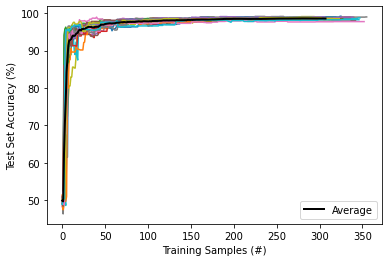

On average, reaches 50.0% accuracy after these training sample counts: [2]
On average, reaches 65.0% accuracy after these training sample counts: [3]
On average, reaches 80.0% accuracy after these training sample counts: [5]
On average, reaches 95.0% accuracy after these training sample counts: [19]


In [359]:
# Choose the same number samples as selected by the algorithm for each run, but randomly
accuracy_vs_trained_samples_all_runs = []

for accuracy_vs_selected_samples in accuracy_vs_selected_samples_all_runs:
    num_samples = len(accuracy_vs_selected_samples)-1
    rand_train_indices = np.random.choice(range(y_train.shape[0]), size=num_samples, replace=False)
    rand_y_train = y_train[rand_train_indices]
    rand_s_train = s_train[rand_train_indices]

    model = MyClassifier(y_train.shape[1])
    accuracy_vs_trained_samples = []

    inferences = model.test(y_test)
    accuracy_vs_trained_samples.append(percentage_correct(inferences, s_test))

    for i in range(num_samples):
        model.train(rand_y_train[0:i+1], rand_s_train[0:i+1])
        inferences = model.test(y_test)
        accuracy_vs_trained_samples.append(percentage_correct(inferences, s_test))

    accuracy_vs_trained_samples_all_runs.append(accuracy_vs_trained_samples)

avg_accuracy_vs_trained_samples = [] # only average up until the last sample for the run with the least samples
for i in range(np.amin(list(len(accuracy_vs_trained_samples_all_runs[i]) for i in range(len(accuracy_vs_trained_samples_all_runs))))):
    avg_accuracy_vs_trained_samples.append(np.mean(list(accuracy_vs_trained_samples_all_runs[j][i] for j in range(len(accuracy_vs_trained_samples_all_runs)))))
avg_accuracy_vs_trained_samples = np.array(avg_accuracy_vs_trained_samples)

# average accuracy after training the last sample in each run
print("Average accuracy: {}".format(np.mean(list(accuracy_vs_trained_samples_all_runs[i][-1] for i in range(len(accuracy_vs_trained_samples_all_runs))))))

for accuracy_vs_trained_samples in accuracy_vs_trained_samples_all_runs:
    accuracy_vs_trained_samples = np.array(accuracy_vs_trained_samples)
    plt.plot(list(range(len(accuracy_vs_trained_samples))), accuracy_vs_trained_samples*100)
plt.plot(list(range(len(avg_accuracy_vs_trained_samples))), avg_accuracy_vs_trained_samples*100, color='black', linewidth=2, label='Average')
plt.xlabel("Training Samples (#)")
plt.ylabel("Test Set Accuracy (%)")
plt.legend()
plt.show()

thresholds = [0.50, 0.65, 0.80, 0.95]
crossing_points = {}
for threshold in thresholds:
    crossing_points[threshold] = []
    under_threshold = True
    for i in range(len(avg_accuracy_vs_trained_samples)):
        if under_threshold and avg_accuracy_vs_trained_samples[i] >= threshold:
            crossing_points[threshold].append(i)
            under_threshold = False
        elif avg_accuracy_vs_trained_samples[i] < threshold:
            under_threshold = True
    print("On average, reaches {}% accuracy after these training sample counts: {}".format(threshold*100, crossing_points[threshold]))

In [360]:
def choose_data(y,s, ratio_to_use):
    N = y.shape[0]
    idxes = np.random.choice(N, size=int(N*ratio_to_use), replace=False)
    y_select = np.take(y, idxes, axis=0)  
    s_select = np.take(s, idxes, axis=0)
    return y_select, s_select

In [361]:
percentage_list = [0.001,0.002,0.003, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
percentage_correct_list = []
for n in percentage_list:
    y_train_select, s_train_select = choose_data(y_train,s_train, n)
    # train all at once
    model = MyClassifier(y_train.shape[1])
    model.train(y_train_select, s_train_select)
    inferences = model.test(y_test)
    percentage_correct_list.append(percentage_correct(inferences, s_test))

Text(0, 0.5, 'Percentage of correct inference on test data (%)')

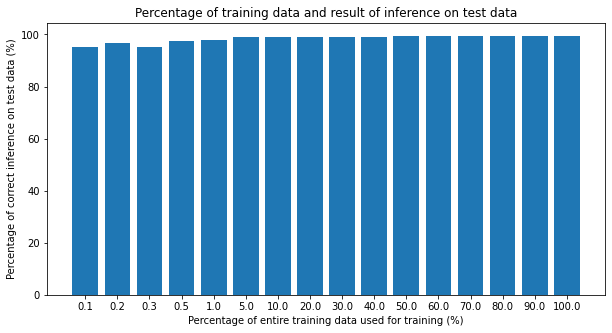

In [362]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.bar([str(p*100) for p in percentage_list], [p*100 for p in percentage_correct_list])
ax.set_title('Percentage of training data and result of inference on test data')
ax.set_xlabel('Percentage of entire training data used for training (%)')
ax.set_ylabel('Percentage of correct inference on test data (%)')
# Not sure what to make of these results; Is it overfitting at around 40% and then generalizing???

In [363]:
def show_test_result(i,ax):
    im = y_test[i].reshape(28,28)
    ax.imshow(im)
    if inferences[i] == 1:
        ax.set_title('1')
    elif inferences[i] == -1:
        ax.set_title('7')

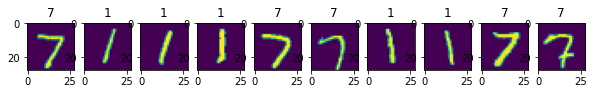

In [364]:
fig, axes = plt.subplots(1,10, figsize=(10,10))
for i, ax in enumerate(axes):
    show_test_result(i, ax)
    